# Model calibrations using ML

## Structure

- given files containing smiles and parameters, extract data
- train network map f: parameters -> smile
- pick smile, train network g: theta_0 -> theta_guess (theta being parameters)


## Authors

Thomas Weber

based on work from:
Dr. Blanka Horvath, Aitor Muguruza Gonzalez, Mehdi Tomas

https://github.com/amuguruza/NN-StochVol-Calibrations/blob/master/1Factor/Flat%20Forward%20Variance/NN1Factor.ipynb

## Extract data

In [1]:
import os
os.chdir("./data")

In [2]:
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [3]:
names = ['$\eta_1$', '$\eta_2$', '$\kappa_1$', '$\kappa_2$', '$\\rho$']+ [str(i)+'x'+str(j)+'-'+m for i in [1,2,5] for j in [1,2,5,10] for m in ['ITM','ATM','OTM']]
df = pd.read_pickle('G2.pkl')
df.describe()

,$\sigma_1$,$\sigma_2$,$\kappa_1$,$\kappa_2$,$\rho$,1x1-ITM,1x1-ATM,1x1-OTM,1x2-ITM,1x2-ATM,...,5x1-OTM,5x2-ITM,5x2-ATM,5x2-OTM,5x5-ITM,5x5-ATM,5x5-OTM,5x8-ITM,5x8-ATM,5x8-OTM
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.010533,0.010586,0.928227,0.930789,-0.486138,0.497629,0.459594,0.426930,0.381406,0.352566,...,0.432183,0.381056,0.352356,0.327562,0.234035,0.216990,0.202044,0.145460,0.135439,0.126540
std,0.005679,0.005676,0.528297,0.526485,0.285038,0.161400,0.148936,0.137736,0.131656,0.121923,...,0.152734,0.165659,0.153196,0.141614,0.149094,0.138301,0.127862,0.124263,0.115425,0.106865
min,0.000100,0.000100,0.000106,0.000140,-0.999945,0.046910,0.043323,0.040390,0.044286,0.040892,...,0.088005,0.096837,0.089433,0.083382,0.081261,0.075421,0.070599,0.042248,0.039419,0.036757
25%,0.005799,0.005877,0.502865,0.506453,-0.729581,0.384152,0.354713,0.330196,0.277591,0.256349,...,0.311815,0.246982,0.228275,0.212843,0.123713,0.114875,0.107276,0.064938,0.060675,0.057043
50%,0.010552,0.010613,0.877235,0.877456,-0.479824,0.487946,0.450844,0.418982,0.362273,0.334579,...,0.403579,0.339147,0.313300,0.291956,0.185029,0.171869,0.160104,0.101339,0.094395,0.088597
75%,0.015362,0.015391,1.331920,1.332892,-0.240241,0.613943,0.567585,0.526479,0.479574,0.443295,...,0.539023,0.481848,0.445854,0.414156,0.296095,0.273800,0.255768,0.173003,0.161395,0.150740
max,0.020500,0.020499,1.999993,1.999970,-0.000014,0.930625,0.854767,0.793651,0.687515,0.642443,...,0.852161,0.970384,0.892219,0.827119,0.974582,0.894476,0.830029,0.998364,0.915657,0.849162


In [4]:
names = df.columns[5:]
params =df.columns[:5]

In [5]:
#df = df[(df != 0).all(1)]
d#f = df.replace(0.0,0.000001)

In [5]:
yy =df[params].to_numpy()
xx =df[names].to_numpy()

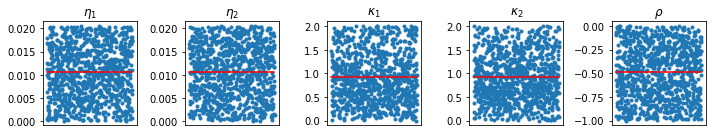

In [6]:
pnames = ['$\eta_1$', '$\eta_2$', '$\kappa_1$', '$\kappa_2$', '$\\rho$']
fig, axes = plt.subplots(1,5,figsize=(10,2))
for i,(ax,param) in enumerate(zip(axes,pnames)):
    ax.plot(yy[:4000:4,i],'.')
    ax.plot([np.mean(yy[:,i]) for j in range(1,1000)],color='r')
    ax.set_title(param)
    ax.set_xticks([])
#fig.delaxes(axes[1,2])
fig.tight_layout() 
plt.savefig('Params.png', dpi=300,bbox_inches='tight')
plt.show()

# Scale and Normalize data

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
y_train, y_test, X_train, X_test  = train_test_split(
    yy, xx, test_size=0.15, random_state=42)

In [9]:
len(X_train[0,:]), len(y_train[0,:])

(36, 5)

In [10]:
from sklearn.preprocessing import StandardScaler

The standard score of a sample x is calculated as: $z=\frac{x-u}{s}$

where $u$ is the mean of the training samples or zero if with_mean=False, and $s$ is the standard deviation of the training samples or one if `with_std=False`.

`fit_transform` computes the mean and std and performs standardizations by centering and scaling.

Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual features do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance).

For instance many elements used in the objective function of a learning algorithm (such as the RBF kernel of Support Vector Machines or the L1 and L2 regularizers of linear models) assume that all features are centered around 0 and have variance in the same order. If a feature has a variance that is orders of magnitude larger that others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.

In [11]:
yscaler = StandardScaler()
y_train_transform, y_test_transform = yscaler.fit_transform(y_train), yscaler.transform(y_test)
xscaler = StandardScaler()
x_train_transform, x_test_transform = xscaler.fit_transform(X_train), xscaler.transform(X_test) # recalculates the parameters of the scaler

https://datascience.stackexchange.com/questions/39932/feature-scaling-both-training-and-test-data

Generally speaking, best practice is to use only the training set to figure out how to scale / normalize, then blindly apply the same transform to the test set.

For example, say you're going to normalize the data by removing the mean and dividing out the variance. If you use the whole dataset to figure out the feature mean and variance, you're using knowledge about the distribution of the test set to set the scale of the training set - 'leaking' information.

The right way to do this is to use only the training set to calculate the mean and variance, normalize the training set, and then at test time, use that same (training) mean and variance to normalize the test set.

As for the point in your question, imagine using the training mean and variance to scale the training set and test mean and variance to scale the test set. Then, for example, a single test example with a value of 1.0 in a particular feature would have a different original value than a training example with a value of 1.0 (because they were scaled differently), but would be treated identically by the model. This is where the bias would come from.

Hier werden die Parameterwerte, nach der Vertauschung oben, bezogen auf einen Upper- und Lower-Bound skaliert.

$$z=2\frac{x-\frac{1}{2}(ub+lb)}{ub-lb}$$

In [ ]:
ub=np.array([0.16,4,10,0])
lb=np.array([0.01,0.5,0,-1])
def myscale(x):
    return 2*(x-0.5*(ub+lb))/(ub-lb)        
def myinverse(x):
    return x*(ub-lb)*0.5+(ub+lb)*0.5

In [ ]:
#x_train_transform = np.array([myscale(x) for x in X_train])
#x_test_transform = np.array([myscale(x) for x in X_test])

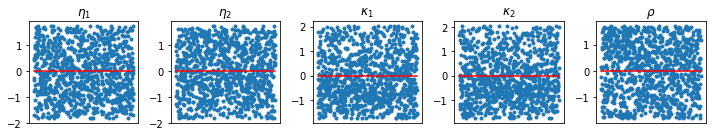

In [12]:
pnames = ['$\eta_1$', '$\eta_2$', '$\kappa_1$', '$\kappa_2$', '$\\rho$']
fig, axes = plt.subplots(1,5,figsize=(10,2))
for i,(ax,param) in enumerate(zip(axes,pnames)):
    ax.plot(y_train_transform[:4000:4,i],'.')
    ax.plot([np.mean(y_train_transform[:,i]) for j in range(1,1000)],color='r')
    ax.set_title(param)
    ax.set_xticks([])
#fig.delaxes(axes[1,2])
fig.tight_layout()
plt.savefig('ParamsTransform.png', dpi=300,bbox_inches='tight')
plt.show()

# Create the Neural Network

In [13]:
from tensorflow import keras

In [14]:
model = keras.models.Sequential([
    keras.Input(name='input',shape=(36)),
    keras.layers.Dense(30,activation = 'elu',name='hidden_1'),
    keras.layers.Dense(30,activation = 'elu',name='hidden_2'),
    keras.layers.Dense(30,activation = 'elu',name='hidden_3'),
    keras.layers.Dense(5,activation = 'linear',name='output')])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Dense)             (None, 30)                1110      
_________________________________________________________________
hidden_2 (Dense)             (None, 30)                930       
_________________________________________________________________
hidden_3 (Dense)             (None, 30)                930       
_________________________________________________________________
output (Dense)               (None, 5)                 155       
Total params: 3,125
Trainable params: 3,125
Non-trainable params: 0
_________________________________________________________________


# Fit the Neural Network

In [16]:
import tensorflow.keras.backend as K

In [17]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [18]:
model.compile(loss = root_mean_squared_error, optimizer = 'adam', metrics=['accuracy'])

In [31]:
history=model.fit(x_train_transform, y_train_transform, batch_size=32,
             validation_data = (x_test_transform,y_test_transform),
             epochs = 200, verbose = 0,shuffle=1)#,callbacks=[earlystop])

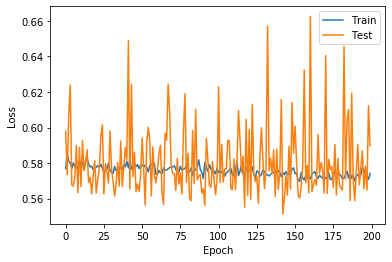

In [32]:
# Plot training & validation accuracy values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.plot(history.history['accuracy'])
#plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.savefig('G2ModelLossR.png', dpi=300,bbox_inches='tight')
plt.show()

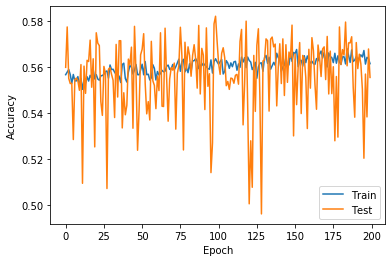

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.title('Model loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.savefig('G2ModelAccuracyR.png', dpi=300,bbox_inches='tight')
plt.show()

https://stackoverflow.com/questions/39561560/getting-gradient-of-model-output-w-r-t-weights-using-keras

https://stackoverflow.com/questions/36968128/saliency-maps-of-neural-networks-using-keras

In [ ]:
#get_output = K.function([model.layers[0].input],model.layers[-1].output,allow_input_downcast=True)
#fx = K.function( [model.layers[0].input] ,T.jacobian(model.layers[-1].output.flatten(),model.layers[0].input), allow_input_downcast=True)
#grad = fx([input_feature])

## Store/Load optimal NN parameteres

In [ ]:
model.save_weights('G2R.h5')

In [ ]:
NNParameters=[layer.get_weights() for layer in model.layers]

# Numpy Implementation of the Neural Network tends to be faster than Keras

In [ ]:
len(NNParameters[0][0])

In [ ]:
NumLayers=3
def elu(x):
    #Careful function ovewrites x
    ind=(x<0)
    x[ind]=np.exp(x[ind])-1
    return x
def eluPrime(y):
    # we make a deep copy of input x
    x=np.copy(y)
    ind=(x<0)
    x[ind]=np.exp(x[ind])
    x[~ind]=1
    return x

In [ ]:
def NeuralNetwork(x):
    input1=x
    for i in range(NumLayers):
        input1=np.dot(input1,NNParameters[i][0])+NNParameters[i][1]
        #Elu activation
        input1=elu(input1)
    #The output layer is linnear
    i+=1
    return np.dot(input1,NNParameters[i][0])+NNParameters[i][1]

In [ ]:
def NeuralNetworkGradient(x):
    input1=x
    #Identity Matrix represents Jacobian with respect to initial parameters
    grad=np.eye(len(x))
    #Propagate the gradient via chain rule
    for i in range(NumLayers):
        input1=(np.dot(input1,NNParameters[i][0])+NNParameters[i][1])
        grad=(np.einsum('ij,jk->ik', grad, NNParameters[i][0]))
        #Elu activation
        grad*=eluPrime(input1)
        input1=elu(input1)
    #input1.append(np.dot(input1[i],NNParameters[i+1][0])+NNParameters[i+1][1])
    grad=np.einsum('ij,jk->ik',grad,NNParameters[i+1][0])
    #grad stores all intermediate Jacobians, however only the last one is used here as output
    return grad
        

https://stackoverflow.com/questions/39561560/getting-gradient-of-model-output-w-r-t-weights-using-keras

In [ ]:
x_train_transform[0]

In [ ]:
NeuralNetwork(x_train_transform[0])

In [ ]:
y_train_transform[0]

In [ ]:
NeuralNetworkGradient(x_train_transform[0])

# Numpy gives 20 fold speed up

In [ ]:
%timeit [NeuralNetwork(x) for x in x_train_transform]

In [ ]:
%timeit model.predict(x_train_transform)

In [ ]:
%timeit NeuralNetworkGradient(x_train_transform[0])

# Compute Implied vol relative errors on Test set

In [ ]:
strikes_dim=len(strikes)
maturities_dim=len(maturities)
strikeslabel=np.round(np.linspace(strikes[0],strikes[-1],8),1)
maturitieslabel=np.array([0.1,0.2, 0.6, 1.5,1.8])

In [33]:
##### AVERAGE VALUES #######
y_sample = yscaler.inverse_transform(y_test_transform)
X_sample = x_test_transform

In [ ]:
y_sample[0]

In [34]:
prediction = np.array(yscaler.inverse_transform(model.predict(X_sample)))
diff =np.abs((y_sample-prediction)/y_sample)

In [36]:
params=['$\eta_1$', '$\eta_2$', '$\kappa_1$', '$\kappa_2$', '$\\rho$']

In [37]:
y_sample.shape

(7500, 5)

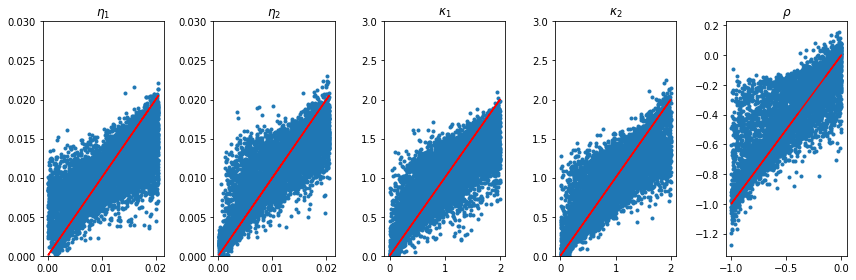

In [40]:
titles=list(params)
fig, axes = plt.subplots(1,5,figsize=(12,4))
for i,(ax,param,xtest,approx) in enumerate(zip(axes,params,y_sample.T,np.array(prediction).T)):
    ax.plot(xtest,approx,'.')
    ax.plot(xtest,xtest,'-r')
    ax.set_title(param)
    if i in [0,1]:
        ax.set_ylim([0,0.03])
    if i in [2,3]:
        ax.set_ylim([0,3])
plt.tight_layout()
plt.savefig('ParameterErrorsR.png', dpi=300)
plt.show()

In [43]:
def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)

In [41]:
paramdiff = np.abs(np.array(y_sample)-np.array(prediction))

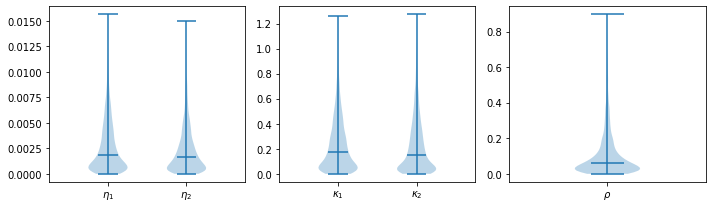

In [45]:
fig, ax = plt.subplots(1,3, figsize=(10, 3))
ax[0].violinplot(list(np.abs(paramdiff).T)[:2],showmedians=True)
set_axis_style(ax[0],['$\eta_1$', '$\eta_2$'])
ax[1].violinplot(list(np.abs(paramdiff).T)[2:4],showmedians=True)
set_axis_style(ax[1],['$\kappa_1$', '$\kappa_2$'])
ax[2].violinplot(list(np.abs(paramdiff).T)[4:],showmedians=True)
set_axis_style(ax[2],['$\\rho$'])
#ax.set_ylim([0,2])
#ax.set_yticks([0,1,2,3,4])
fig.tight_layout()   
plt.savefig('EtaViolinR.png', dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
results = [{'title': "Average error",
            'data': np.mean(100*diff,axis = 0)},
           {'title': "Std error",
            'data': 100*np.std(diff,axis = 0)},
           {'title': "Maximum error",
            'data': 100*np.max(diff,axis = 0)}
          ] 

In [ ]:
strikes = ['ITM','ATM','OTM']
maturities= [1,2,5,8]

In [ ]:
xticks = np.array([[int(i),strike] for i,strike in enumerate(strikes)]).transpose()
yticks = np.array([[i,mat] for i, mat in enumerate(maturities)]).transpose()
shape = (3,4,3)

In [ ]:
xticks =[[i for i,_ in enumerate(strikes)],strikes]
yticks =[[i+1 for i,_ in enumerate(maturities)],list(reversed(maturities))]

In [ ]:
fig, axis = plt.subplots(3,3,figsize=(11,10))
for i in range(3):
    for j,(ax,result) in enumerate(zip(axis[i],results)):
        im =ax.imshow(result['data'].reshape(3,4,3)[i],cmap='gray_r')
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        ax.set_ylim([5,0])
        if i ==0:
            ax.set_title(result['title'],fontsize=15,y=1.04)
        if i==2:
            ax.set_xticks(xticks[0])
            ax.set_xticklabels(xticks[1])
        else:
            ax.set_xticks([])  
        #ax.set_xlabel("Moneyness",fontsize=12,labelpad=5)
        if j ==0:
            ax.set_ylabel("Tenor",fontsize=12,labelpad=5)
            ax.set_yticks(yticks[0])
            ax.set_yticklabels(yticks[1]) 
        else:
            ax.set_yticks([])  
fig.tight_layout()    
plt.savefig('G2TestErrors.png', dpi=300,bbox_inches='tight')
plt.show()

# Plot sample Smiles

In [ ]:
sample_ind = 125
y_sample = y_test[sample_ind]
X_sample = x_test_transform[sample_ind]
print(xscaler.inverse_transform(X_sample))

In [ ]:
y_sample = y_test[sample_ind].reshape(shape)
NN_approx=prediction[sample_ind].reshape(shape)

In [ ]:
fig, ax = plt.subplots(1,1)
for sample,approx,m in zip(y_sample[0],NN_approx[0],maturities):
    ax.plot(strikes,sample,'-ob',linewidth=0.5)
    ax.plot(strikes,approx,'--or',linewidth=0.5)
    t = ax.text(1.5,(sample[-1]+approx[-1])/2,"Mat.=%d "%m)
    t.set_bbox(dict(facecolor='white', alpha=1,edgecolor='white'))
plt.tight_layout()
plt.show()

In [ ]:
names = ['$\eta_1$', '$\eta_2$', '$\kappa_1$', '$\kappa_2$', '$\\rho$']+ [str(i)+'x'+str(j)+'-'+m for i in [1,2,5] for j in [1,2,5,8] for m in ['ITM','ATM','OTM']]


In [ ]:
from matplotlib.lines import Line2D

In [ ]:
colors = ['blue', 'red']
linestyles =['-','--']
lines = [Line2D([0], [0], color=c, linewidth=0.5, linestyle=l) for c,l in zip(colors,linestyles)]
labels = ['Testdaten', 'NN']

In [ ]:
fig, axis = plt.subplots(1,3,figsize=(8,5))
#plt.figure(1,figsize=(14,12))
for i,(ax,samples,approxs,mat) in enumerate(zip(axis,y_sample,NN_approx,[1,2,5])):
    for sample,approx,m in zip(samples,approxs,maturities):
        ax.plot(strikes,sample,'-ob',linewidth=0.5)
        ax.plot(strikes,approx,'--or',linewidth=0.5)
        t = ax.text(1.3,(sample[-1]+approx[-1])/2,"Tenor=%d "%m)
        t.set_bbox(dict(facecolor='white', alpha=0.7,edgecolor='white')) 
    ax.set_title("Maturity=%d "%mat)
    ax.set_xlabel("moneyness")
    ax.set_ylabel("Implied vol")   
    ax.legend(lines, labels)
plt.tight_layout()
plt.savefig('Sample125.png', dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
sample_ind= np.argmin([sum(d) for d in diff])

In [ ]:
y_sample = y_test[sample_ind].reshape(shape)
NN_approx=prediction[sample_ind].reshape(shape)
fig, axis = plt.subplots(1,3,figsize=(8,5))
#plt.figure(1,figsize=(14,12))
for i,(ax,samples,approxs,mat) in enumerate(zip(axis,y_sample,NN_approx,[1,2,5])):
    for sample,approx,m in zip(samples,approxs,maturities):
        ax.plot(strikes,sample,'-ob',linewidth=0.5)
        ax.plot(strikes,approx,'--or',linewidth=0.5)
        t = ax.text(1.3,(sample[-1]+approx[-1])/2,"Tenor=%d "%m)
        t.set_bbox(dict(facecolor='white', alpha=0.7,edgecolor='white')) 
    ax.set_title("Maturity=%d "%mat)
    ax.set_xlabel("moneyness")
    ax.set_ylabel("Market vol")   
    ax.legend(lines, labels)
plt.tight_layout()
plt.savefig('Sample'+str(sample_ind)+'.png', dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
sample_ind=np.argmax([sum(d) for d in diff])

In [ ]:
y_sample = y_test[sample_ind].reshape(shape)
NN_approx=prediction[sample_ind].reshape(shape)
fig, axis = plt.subplots(1,3,figsize=(8,5))
#plt.figure(1,figsize=(14,12))
for i,(ax,samples,approxs,mat) in enumerate(zip(axis,y_sample,NN_approx,[1,2,5])):
    for sample,approx,m in zip(samples,approxs,maturities):
        ax.plot(strikes,sample,'-ob',linewidth=0.5)
        ax.plot(strikes,approx,'--or',linewidth=0.5)
        t = ax.text(1.3,(sample[-1]+approx[-1])/2,"Tenor=%d "%m)
        t.set_bbox(dict(facecolor='white', alpha=0.7,edgecolor='white')) 
    ax.set_title("Maturity=%d "%mat)
    ax.set_xlabel("moneyness")
    ax.set_ylabel("Market vol")   
    ax.legend(lines, labels)
plt.tight_layout()
plt.savefig('Sample'+str(sample_ind)+'.png', dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
sample_ind = 445
y_sample = y_test[sample_ind].reshape(shape)
NN_approx=prediction[sample_ind].reshape(shape)

In [ ]:
snames = [str(i)+'x'+str(j)+'-'+m for i in [1,2,5] for j in [1,2,5,8] for m in ['ITM','ATM','OTM']]
snames[:12]

In [ ]:
def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)

In [ ]:
data = [sorted([dd[i] for dd in diff]) for i in range(36)]
samples = [sorted([dd[i] for dd in yscaler.inverse_transform(y_test_transform)]) for i in range(36)]
snames = [[str(i)+'x'+str(j) for j in [1,2,5,8]] for i in [1,2,5]]

In [ ]:
shape

In [ ]:
data1=np.array(data).reshape(3,4,3,-1)
samples1 = np.array(samples).reshape(3,4,3,-1)

In [ ]:
np.mean(data[1]),np.mean(data1[0,0,1])

In [ ]:
data1[0,0,0][:10]

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 3), sharey=True)
ax.set_title(snames[0])
ax.set_ylabel('Absol. Differenz')
ax.violinplot(list(data1[0,0]))
ax.set_ylim([0,0.03])
set_axis_style(ax,strikes)
plt.show()

snames = [[str(i)+'x'+str(j) for j in [1,2,5,8]] for i in [1,2,5]]

In [ ]:
snames

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 9), sharey=True,sharex=True)
for subaxes,data,sname in zip(axes,data1,snames):
    for ax,dd,m in zip(subaxes,data,sname):
        #ax.set_title(snames[0])
        #ax.set_ylabel('Absol. Differenz')
        ax.violinplot(list(dd),showmedians=True)
        ax.set_ylim([0,0.04])
        ax.set_yticks([0.00,0.02,0.04])
        set_axis_style(ax,strikes)
        ax.set_title(m)
fig.tight_layout()   
plt.savefig('SampleDiffViolin.png', dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
data1.shape

In [ ]:
samples1.shape

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 9), sharey=True,sharex=True)
for subaxes,data,sname in zip(axes,samples1,snames):
    for ax,dd,m in zip(subaxes,data,sname):
        #ax.set_title(snames[0])
        #ax.set_ylabel('Absol. Differenz')
        ax.violinplot(list(dd),showmedians=True)
        #ax.set_ylim([0,0.04])
        #ax.set_yticks([0.00,0.02,0.04])
        set_axis_style(ax,strikes)
        ax.set_title(m)
fig.tight_layout()   
plt.savefig('SampleValues.png', dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
sample_ind = 500
y_sample = y_test[sample_ind].reshape(shape)
NN_approx=prediction[sample_ind].reshape(shape)

print(xscaler.inverse_transform(X_sample))
S0=1.

fig, axis = plt.subplots(2,4,figsize=(14,7))
#plt.figure(1,figsize=(14,12))
for i,(ax, m) in enumerate(zip([ax for sublist in axis for ax in sublist],maturities)):
    ax.plot(strikes,y_sample[i],'b',label="Input data")
    ax.plot(strikes,NN_approx[i],'--r',label=" NN Approx")
  
    ax.set_title("Maturity=%1.2f "%m)
    ax.set_xlabel("moneyness")
    ax.set_ylabel("Implied vol")   
    ax.legend()
plt.tight_layout()
plt.show()

# Use gradient methods for optimization

In [ ]:
#Cost Function for Levenberg Marquardt
def CostFuncLS(y,sample_ind):
    return (NeuralNetwork(y)-y_test_transform[sample_ind])
def JacobianLS(y,sample_ind):
    return NeuralNetworkGradient(y).T

In [ ]:
import time
from scipy.optimize import minimize, least_squares

In [ ]:
Approx=[]


In [ ]:
Approx=[]
for i,_ in enumerate(X_test):
    print (str(i+1)+"/5000",end="\r")
    #Levenberg-Marquardt
    I=least_squares(CostFuncLS,np.zeros(5), JacobianLS,args=(i,),gtol=1E-10)
    Approx.append(xscaler.inverse_transform(I.x))


# Save the Lavenberg-Marquardt Optimal parameters

In [ ]:
LMParameters = Approx[0]

`X_test` is the result from the split in train and test data from sk_learn

In [ ]:
len(y_test),X_test[0]

# Calibration Errors with Levenberg-Marquardt

In [ ]:
LMParameters=Approx

In [ ]:
list(params)

In [ ]:
titles=list(params)
average=np.zeros([4,5000])
fig=plt.figure(figsize=(12,8))
for u in range(4):
    ax=plt.subplot(2,2,u+1)
    for i in range(5000):     
        x=X_test[i][u]
        plt.plot(x,np.abs(LMParameters[i][u]-x),'b*')
        average[u,i]=np.abs(LMParameters[i][u]-x)
    plt.title(titles[u],fontsize=20)
    plt.ylabel('absoluter Fehler',fontsize=15)
    #plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.tick_params(axis='both', which='minor', labelsize=15)
    plt.text(0.5, 0.8, 'Average: %1.2f\n Median:   %1.2f'%(np.mean(average[u,:])
            ,np.quantile(average[u,:],0.5)), 
             horizontalalignment='center',
             verticalalignment='center', 
             transform=ax.transAxes,fontsize=15)

plt.tight_layout()
plt.savefig('ParameterErrors.png', dpi=300)
plt.show()

In [ ]:
paramdiff = (np.abs(np.array(X_test)-np.array(Approx))

In [ ]:
titles=list(params)
fig, axes = plt.subplots(1,5,figsize=(12,4))
for i,(ax,param,xtest,approx) in enumerate(zip(axes,pnames,X_test.T,np.array(Approx).T)):
    ax.plot(xtest,approx,'.')
    ax.plot(xtest,xtest,'-r')
    ax.set_title(param)
plt.tight_layout()
plt.savefig('ParameterErrors.png', dpi=300)
plt.show()

In [ ]:
Approx=LMParameters

# Load corresponding smile generated by Monte Carlo

In [ ]:
SurfacesCalib=np.loadtxt("surfacesFromNN1FBergomi.txt")
SurfacesCalib=SurfacesCalib[:,4:]
SurfacesTarget=y_test[:5000]
#print(Surfaces2Params)

RMSENN=np.sqrt(np.mean(np.power(SurfacesCalib-SurfacesTarget,2),axis=1))
ind=~(RMSENN==np.inf)
nind=(RMSENN==np.inf)
y_test_prime=y_test[:5000,:][ind,:]
RMSENN=RMSENN[ind]

In [ ]:
X_test_prime_n=X_test[:5000,:][nind,:]

In [ ]:
len(X_test_prime_n)

In [ ]:
X_test_prime_n

In [ ]:
plt.figure(figsize=(18, 5))
plt.clf()
plt.subplot(121)


ax = plt.gca()
q=np.linspace(0,0.99,200)
for u,title in enumerate(titles):
    p=plt.plot(100*q,np.quantile(100*average[u,:],q),label=title)  
    c=p[0].get_color()
ymin, ymax = ax.get_ylim()
ax.set_xlim(0,100)
plt.plot(100*np.ones(2)*0.95,np.array([0,ymax]),'--k',label="95% quantile")

plt.title("Empirical CDF of parameter relative error",fontsize=20)
plt.legend(fontsize=17)
plt.xlabel("quantiles",fontsize=17)
plt.ylabel("relative error",fontsize=17)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter() )
plt.tick_params(axis='both', which='major', labelsize=17)
plt.tick_params(axis='both', which='minor', labelsize=17)
plt.xticks(np.arange(0, 101, step=10))

plt.grid()
plt.subplot(122)


ax = plt.gca()
q=np.linspace(0,1,200)
p=plt.plot(100*q,np.quantile(100*RMSENN,q),linewidth=3,label="RMSE")
ymin, ymax = ax.get_ylim()
plt.plot(100*np.ones(2)*0.99,np.array([0,ymax]),'--k',label="99% quantile")
plt.title("Empirical CDF of implied vol surface RMSE",fontsize=20)
plt.legend(fontsize=17)
plt.xlabel("quantiles",fontsize=17)
plt.ylabel("RMSE",fontsize=17)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter() )
plt.tick_params(axis='both', which='major', labelsize=17)
plt.tick_params(axis='both', which='minor', labelsize=17)
plt.xticks(np.arange(0, 101, step=10))
plt.grid()
plt.savefig('ErrorCDF.png', dpi=300)
plt.show()
